In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

### 1st level

In [141]:
data = pd.read_csv('C:\\Users\\ksn\\archive\\rating_complete.csv')
data_100000 = data[:100000]
print(len(data))
data.head(2)

57633278


,user_id,anime_id,rating
0,0,430,9
1,0,1004,5


In [142]:
data_mal = pd.read_csv('C:\\Users\\ksn\\archive\\anime.csv')
data_mal.head(1)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0


In [143]:
data_train = data
me = pd.read_csv('400000.csv')

In [144]:
popularity_anime = data_train.groupby('anime_id')['rating'].sum().reset_index().sort_values('rating', ascending=False)
popularity_anime.head(3)

,anime_id,rating
1390,1535,1587860
7437,16498,1445712
3965,5114,1239579


In [145]:
# top_anime = popularity_anime.reset_index(drop=True)[:10000]
# top_anime = top_anime['anime_id'].tolist()

In [146]:
popularity_anime = popularity_anime.reset_index(drop=True)
popularity_anime['rating_rank'] = popularity_anime.index
popularity_anime.drop('rating', axis=1, inplace=True)
popularity_anime.head(3)

,anime_id,rating_rank
0,1535,0
1,16498,1
2,5114,2


In [147]:
data_train = pd.merge(data_train, popularity_anime, how='left', on='anime_id')

In [148]:
data_train.head(3)

,user_id,anime_id,rating,rating_rank
0,0,430,9,229
1,0,1004,5,832
2,0,3010,7,4200


In [149]:
user_rating = data_train.groupby('user_id')['rating_rank'].sum().reset_index().sort_values('rating_rank', ascending=False).reset_index(drop=True)
user_rating.head(3)

,user_id,rating_rank
0,189037,125345649
1,162615,121198749
2,68042,100797227


In [150]:
user_val = data_train.groupby('user_id')['rating_rank'].count().reset_index().sort_values('rating_rank', ascending=False).reset_index(drop=True)
user_val.head(3)

,user_id,rating_rank
0,189037,15455
1,162615,14864
2,68042,13462


In [151]:
user_rating = pd.merge(user_rating, user_val, how='left', on='user_id')
user_rating['rating_rank'] = user_rating['rating_rank_x']/user_rating['rating_rank_y']
user_rating.drop(['rating_rank_x', 'rating_rank_y'], axis=1, inplace=True)
user_rating.head(3)

,user_id,rating_rank
0,189037,8110.362278
1,162615,8153.844793
2,68042,7487.537290


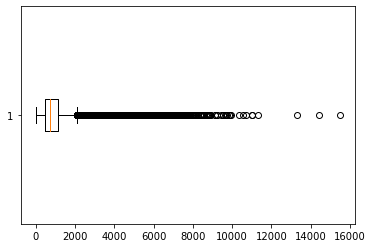

In [152]:
plt.boxplot(user_rating['rating_rank'], vert=False)
plt.show()

In [153]:
user_rating = user_rating.loc[(user_rating['rating_rank'] < 12000) & (user_rating['rating_rank'] > 2500)]

In [154]:
user_list = user_rating['user_id'].tolist()

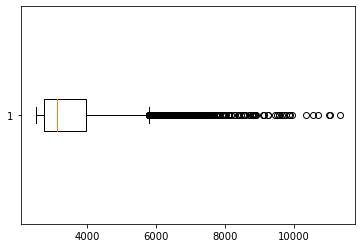

In [155]:
plt.boxplot(user_rating['rating_rank'], vert=False)
plt.show()

In [156]:
# data_train = data_train.loc[data_train['anime_id'].isin(top_anime)]
# data_train.head(3)

In [157]:
data_train = data_train.loc[data_train['user_id'].isin(user_list)]
data_train = pd.concat([data_train, me], ignore_index=True)
len(data_train)

4262829

In [158]:
import pandas as pd
import numpy as np

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import ItemItemRecommender  # нужен для одного трюка
from implicit.nearest_neighbours import bm25_weight, tfidf_weight


class MainRecommender:
    """Рекоммендации, которые можно получить из ALS"""

    def __init__(self, data, weighting=True):
        # your_code. Это не обязательная часть. Но если вам удобно что-либо посчитать тут - можно это сделать

        self.user_item_matrix = self.prepare_matrix(data)  # pd.DataFrame
        self.id_to_itemid, self.id_to_userid, self.itemid_to_id, self.userid_to_id = self.prepare_dicts(
            self.user_item_matrix)
        self.top100 = self.top_100(data)

        if weighting:
            self.user_item_matrix = bm25_weight(self.user_item_matrix.T).T

        self.model_als = self.fit_als(self.user_item_matrix)
        self.own_recommender = self.fit_own_recommender(self.user_item_matrix)
        self.similar_users_recommender = self.fit_similar_users_recommender(self.user_item_matrix)


    @staticmethod
    def top_100(data):
        popularity = data.groupby('anime_id')['rating'].sum().reset_index()
        top_100 = popularity.sort_values('rating', ascending=False).head(100).anime_id.tolist()
        return top_100


    @staticmethod
    def prepare_matrix(data):
        user_item_matrix = pd.pivot_table(data,
                                          index='user_id', columns='anime_id',
                                          values='rating',
                                          fill_value=0)
        
        user_item_matrix = user_item_matrix.astype(float)  # необходимый тип матрицы для implicit

        return user_item_matrix

    @staticmethod
    def prepare_dicts(user_item_matrix):
        """Подготавливает вспомогательные словари"""

        userids = user_item_matrix.index.values
        itemids = user_item_matrix.columns.values

        matrix_userids = np.arange(len(userids))
        matrix_itemids = np.arange(len(itemids))

        id_to_itemid = dict(zip(matrix_itemids, itemids))
        id_to_userid = dict(zip(matrix_userids, userids))

        itemid_to_id = dict(zip(itemids, matrix_itemids))
        userid_to_id = dict(zip(userids, matrix_userids))

        return id_to_itemid, id_to_userid, itemid_to_id, userid_to_id


    @staticmethod
    def fit_own_recommender(user_item_matrix):
        """Обучает модель, которая рекомендует товары, среди товаров, купленных юзером"""
        own_recommender = ItemItemRecommender(K=1, num_threads=0)
        own_recommender.fit(csr_matrix(user_item_matrix).T.tocsr())

        return own_recommender


    @staticmethod
    def fit_als(user_item_matrix):
        """Обучает ALS"""

        model = AlternatingLeastSquares(factors=20,
                                        regularization=0.001,
                                        iterations=15,
                                        num_threads=0)
        model.fit(csr_matrix(user_item_matrix).T.tocsr())

        return model


    @staticmethod
    def fit_similar_users_recommender(user_item_matrix):
        """Обучает модель, которая рекомендует товары, среди товаров, купленных 5 похожими юзерами"""
        own_recommender = ItemItemRecommender(K=5, num_threads=0)
        own_recommender.fit(csr_matrix(user_item_matrix).T.tocsr())
        return own_recommender


    def get_als_recommendations(self, user, N):
        try:
            res = [self.id_to_itemid[rec[0]] for rec in
                   self.model_als.recommend(userid=self.userid_to_id[user],
                                   user_items=csr_matrix(self.user_item_matrix).tocsr(),  # на вход user-item matrix
                                   N=N,
                                   filter_already_liked_items=False,
                                   filter_items=[self.itemid_to_id[999999]],  # !!! 999999
                                   recalculate_user=True)]
        except KeyError:
            res = []

        if len(res) != N:
            n = N - len(res)
            res.extend([_ for _ in np.random.choice(self.top100, n)])

        assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
        return res


    def get_similar_items_recommendation(self, user, N):
        """Рекомендуем товары, похожие на топ-N купленных юзером товаров"""
        try:
            res = [self.id_to_itemid[rec[0]] for rec in
                   self.own_recommender.recommend(userid=self.userid_to_id[user],
                                   user_items=csr_matrix(self.user_item_matrix).tocsr(),  # на вход user-item matrix
                                   N=N,
                                   filter_already_liked_items=False,
                                   filter_items=[self.itemid_to_id[999999]],  # !!!
                                   recalculate_user=True)]
        except KeyError:
            res = []

        if len(res) != N:
            n = N - len(res)
            res.extend([_ for _ in np.random.choice(self.top100, n)])

        assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
        return res


    def get_own_recommendations(self, user, N):
        """Рекомендуем товары, похожие на топ-N купленных юзером товаров"""
        try:
            res = [self.id_to_itemid[rec[0]] for rec in
                   self.own_recommender.recommend(userid=self.userid_to_id[user],
                                   user_items=csr_matrix(self.user_item_matrix).tocsr(),  # на вход user-item matrix
                                   N=N,
                                   filter_already_liked_items=False,
                                   filter_items=[self.itemid_to_id[999999]],  # !!!
                                   recalculate_user=True)]
        except KeyError:
            res = []

        if len(res) != N:
            n = N - len(res)
            res.extend([_ for _ in np.random.choice(self.top100, n)])

        assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
        return res


    def get_similar_users_recommendation(self, user, N):
        """Рекомендуем топ-N товаров, среди купленных 5 похожими юзерами"""
        try:
            res = [self.id_to_itemid[rec[0]] for rec in
                   self.similar_users_recommender.recommend(userid=self.userid_to_id[user],
                                   user_items=csr_matrix(self.user_item_matrix).tocsr(),  # на вход user-item matrix
                                   N=N,
                                   filter_already_liked_items=False,
                                   filter_items=[self.itemid_to_id[999999]],  # !!!
                                   recalculate_user=True)]
        except KeyError:
            res = []

        if len(res) != N:
            n = N - len(res)
            res.extend([_ for _ in np.random.choice(self.top100, n)])

        assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
        return res

In [159]:
recommender = MainRecommender(data_train)

In [160]:
list_als = recommender.get_als_recommendations(400000, N=100)
sum([data_mal.loc[data_mal['MAL_ID'] == i]['Popularity'].values for i in list_als])[0]

17620

In [161]:
list_own = recommender.get_own_recommendations(400000, N=100)
sum([data_mal.loc[data_mal['MAL_ID'] == i]['Popularity'].values for i in list_own])[0]

18287

In [162]:
list_si = recommender.get_similar_items_recommendation(400000, N=100)
sum([data_mal.loc[data_mal['MAL_ID'] == i]['Popularity'].values for i in list_si])[0]

15143

In [163]:
list_su = recommender.get_similar_users_recommendation(400000, N=100)
sum([data_mal.loc[data_mal['MAL_ID'] == i]['Popularity'].values for i in list_su])[0]

15166

### 2nd level

In [164]:
genres = []

for i in range(len(data_mal)):
    genres.extend(data_mal.iloc[i]['Genres'].split(', '))

colms = list(set(genres))

In [165]:
data_genres = pd.DataFrame(columns=colms)
data_genres['anime_id'] = data_mal['MAL_ID']
data_genres = data_genres.fillna(0)

In [166]:
for i in range(len(data_mal)):
    list_genres = data_mal.loc[i]['Genres'].split(', ')
    for j in list_genres:
        data_genres.at[i, j] = 1
        
data_genres.head(3)

,Demons,Shounen,Kids,Parody,Magic,Sports,Action,Adventure,Thriller,Samurai,...,Seinen,School,Space,Military,Fantasy,Super Power,Josei,Comedy,Music,anime_id
0,0,0,0,0,0,0,1,1,0,0,...,0,0,1,0,0,0,0,1,0,1
1,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,5
2,0,1,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,6


In [167]:
# data_genres = data_genres.loc[data_genres['anime_id'].isin(top_anime)]

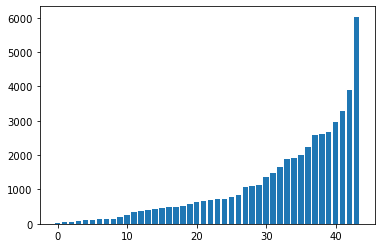

In [168]:
list_sum_col = []
for i in data_genres.columns:
    if i != 'anime_id':
        list_sum_col.append(sum(data_genres[i]))
    
plt.bar([i for i in range(len(list_sum_col))], height=sorted(list_sum_col))
plt.show()

In [169]:
for i in data_genres.columns:
    if i != 'anime_id' and sum(data_genres[i]) < 500:
        data_genres.drop(i, axis=1, inplace=True)

In [170]:
me_genres = pd.merge(me['anime_id'], data_genres, how='left', on='anime_id').mode().loc[0][1:].values

def rec_fin(list_rec):
    list_corr = []
    list_anime_name = []
    list_anime_url = []

    for i in list_rec:
        list_corr.append(np.corrcoef(me_genres, data_genres.loc[data_genres['anime_id'] == i].values[0][:-1])[0, 1])
        list_anime_name.append(data_mal.loc[data_mal['MAL_ID'] == i]['Name'].values[0])
        list_anime_url.append('https://myanimelist.net/anime/' + str(i))
    
    return pd.DataFrame({'anime_id': list_rec, 'corr': list_corr, 'name': list_anime_name, 'url': list_anime_url}).sort_values('corr', ascending=False).drop_duplicates().head(50)

rec_fin(list_als)

,anime_id,corr,name,url
30,5680,0.847791,K-On!,https://myanimelist.net/anime/5680
69,4224,0.847791,Toradora!,https://myanimelist.net/anime/4224
36,1887,0.847791,Lucky☆Star,https://myanimelist.net/anime/1887
25,849,0.661438,Suzumiya Haruhi no Yuuutsu,https://myanimelist.net/anime/849
44,853,0.516047,Ouran Koukou Host Club,https://myanimelist.net/anime/853
59,32182,0.516047,Mob Psycho 100,https://myanimelist.net/anime/32182
34,4181,0.438230,Clannad: After Story,https://myanimelist.net/anime/4181
39,18679,0.438230,Kill la Kill,https://myanimelist.net/anime/18679
19,33486,0.438230,Boku no Hero Academia 2nd Season,https://myanimelist.net/anime/33486
75,5681,0.350000,Summer Wars,https://myanimelist.net/anime/5681


In [171]:
rec_fin(list_own)

,anime_id,corr,name,url
53,4224,0.847791,Toradora!,https://myanimelist.net/anime/4224
35,1887,0.847791,Lucky☆Star,https://myanimelist.net/anime/1887
4,245,0.741620,Great Teacher Onizuka,https://myanimelist.net/anime/245
50,849,0.661438,Suzumiya Haruhi no Yuuutsu,https://myanimelist.net/anime/849
77,2167,0.661438,Clannad,https://myanimelist.net/anime/2167
31,31964,0.438230,Boku no Hero Academia,https://myanimelist.net/anime/31964
93,33486,0.438230,Boku no Hero Academia 2nd Season,https://myanimelist.net/anime/33486
19,5681,0.350000,Summer Wars,https://myanimelist.net/anime/5681
36,759,0.350000,Tokyo Godfathers,https://myanimelist.net/anime/759
87,12355,0.350000,Ookami Kodomo no Ame to Yuki,https://myanimelist.net/anime/12355


In [172]:
rec_fin(list_si)

,anime_id,corr,name,url
37,5680,0.847791,K-On!,https://myanimelist.net/anime/5680
47,1887,0.847791,Lucky☆Star,https://myanimelist.net/anime/1887
73,4224,0.847791,Toradora!,https://myanimelist.net/anime/4224
60,2167,0.661438,Clannad,https://myanimelist.net/anime/2167
43,849,0.661438,Suzumiya Haruhi no Yuuutsu,https://myanimelist.net/anime/849
98,853,0.516047,Ouran Koukou Host Club,https://myanimelist.net/anime/853
40,32182,0.516047,Mob Psycho 100,https://myanimelist.net/anime/32182
94,4181,0.438230,Clannad: After Story,https://myanimelist.net/anime/4181
67,18679,0.438230,Kill la Kill,https://myanimelist.net/anime/18679
55,31964,0.438230,Boku no Hero Academia,https://myanimelist.net/anime/31964


In [173]:
rec_fin(list_su)

,anime_id,corr,name,url
3,4224,0.847791,Toradora!,https://myanimelist.net/anime/4224
18,245,0.741620,Great Teacher Onizuka,https://myanimelist.net/anime/245
1,849,0.661438,Suzumiya Haruhi no Yuuutsu,https://myanimelist.net/anime/849
63,2167,0.661438,Clannad,https://myanimelist.net/anime/2167
57,853,0.516047,Ouran Koukou Host Club,https://myanimelist.net/anime/853
67,4181,0.438230,Clannad: After Story,https://myanimelist.net/anime/4181
91,6547,0.438230,Angel Beats!,https://myanimelist.net/anime/6547
58,18679,0.438230,Kill la Kill,https://myanimelist.net/anime/18679
79,33486,0.438230,Boku no Hero Academia 2nd Season,https://myanimelist.net/anime/33486
49,5681,0.350000,Summer Wars,https://myanimelist.net/anime/5681
